EDA for project LENTA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

In [2]:
pr_df = pd.read_csv("C:\\Users\\Star\\Downloads\\sp_sales_task\\pr_df.csv")

pr_df.csv – данные по товарной иерархии. 

От большего к меньшему pr_group_id - pr_cat_id - pr_subcat_id - pr_sku_id.

Столбцы: 
    
pr_group_id – захэшированная группа товара; 

pr_cat_id – захэшированная категория товара; 

pr_subcat_id – захэшированная подкатегория товара;

pr_sku_id – захэшированное id товара;

pr_uom_id (маркер, обозначающий продаётся товар на вес или в ШТ).



In [3]:
sales_df_train = pd.read_csv('C:\\Users\\Star\\Downloads\\sp_sales_task\\sales_df_train.csv')

sales_df_train.csv –данные по продажам за скользящий год для обучения. 

Столбцы: 
    
st_id – захэшированное id магазина;

pr_sku_id – захэшированное id товара;

date – дата;

pr_sales_type_id – флаг наличия промо;

pr_sales_in_units – число проданных товаров без признака промо;

pr_promo_sales_in_units – число проданных товаров с признаком промо;

pr_sales_in_rub – продажи без признака промо в РУБ;

pr_promo_sales_in_rub – продажи с признаком промо в РУБ;


In [4]:
sales_submission = pd.read_csv('C:\\Users\\Star\\Downloads\\sp_sales_task\\sales_submission.csv')

sales_submission.csv – пример файла с результатом работы модели прогноза спроса. 

Необходимо подготовить файл в таком же формате, заполнив колонку target предсказаниями (по умолчанию колонка заполнена нулями). 

Столбцы:
    
st_id – захэшированное id магазина; 

pr_sku_id – захэшированное id товара;

date – дата (день);

target – спрос в ШТ

In [5]:
st_df = pd.read_csv('C:\\Users\\Star\\Downloads\\sp_sales_task\\st_df.csv')

st_df.csv – данные по магазинам. 

Столбцы: 
    
st_id – захэшированное id магазина;

st_city_id – захэшированное id города;

st_division_code id – захэшированное id дивизиона;

st_type_format_id – id формата магазина; 

st_type_loc_id – id тип локации/окружения магазина;

st_type_size_id – id типа размера магазина;

st_is_active – флаг активного магазина на данный момент.


In [6]:
def def_about(data):
    
    print('Tип данных, диапазон, столбцы, количество записей в каждом столбце, если столбцы не равны нулю')
    print('                                  ')
    data.info()
    print('                                  ')      
    print('Пример случайных строк из датасета')
    print('                                  ')     
    display(data.sample(n=10, random_state=12345))
    print('                                  ')     
    print('Разброс значений, среднее и медиана')
    print('                                  ')    
    print(data.describe().T)
    print('                                  ') 
    len_data = len(data)
    print('Количество записей: \t {0}'.format(len_data))
    print('                                  ') 
    print('Количество столбцов: \t {0}'.format(len(data.columns)))
    print('                                  ') 
    count = 0
    for col in data.columns:
        notnull = data[col].notna().sum()
        if notnull < len_data:
            count+=1
    print('Пропуски присутствуют в {} столбцах из {}'.format(count,len(data.columns)))
    print('                                  ') 
    print('Количество явных дубликатов данных: {}'.format(data.duplicated().sum()))
    print('                                  ') 
    

In [7]:
def_about(pr_df)

Tип данных, диапазон, столбцы, количество записей в каждом столбце, если столбцы не равны нулю
                                  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB
                                  
Пример случайных строк из датасета
                                  


,pr_sku_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id
1713,4792d399b0cc6e8223fdb5b130e9387f,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,8feef08314d477a5b68ba18a6d35819d,17
467,6dc2d6abe22eaa15ea066134c983f2ac,c20ad4d76fe97759aa27a0c99bff6710,fb2fcd534b0ff3bbed73cc51df620323,f222c0d412b9a812f556597c95540276,1
1380,e8d0f573ac95947eeb28ff622fade5c6,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,41b1d51c9e3ba9a263361f9cfa0eb434,17
763,5839d00df7c33f98615fd2aaf9c87389,6512bd43d9caa6e02c990b0a82652dca,e58cc5ca94270acaceed13bc82dfedf7,c93c26cd49ea08e6b8984351d4164575,1
989,426157fed5629835a7d6217bbefccac9,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,6bae9a61fa499b24f28c3ddcef6ccb1b,1
666,ef483b1a0ab164698fe9b232706f66ab,aab3238922bcc25a6f606eb525ffdc56,3de2334a314a7a72721f1f74a6cb4cee,cdfcda17c8ab17c2b917505c0264e471,17
1321,1142167b4bf803ff64a3ddc2e2211a2d,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,485095ca4d0494dc265ad8de07ec107b,1
686,05a0b334e897df620ab915d173636099,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,cf6faa5b09823f159e09a786cba0dd88,1
462,be2eb3bcc9ebeba04e0441004e9a674b,c51ce410c124a10e0db5e4b97fc2af39,fd5c905bcd8c3348ad1b35d7231ee2b1,3dde95bfddfc5c387eb9e7b7a77dfa63,1
331,1315c014e0e20f2ffbe8c0bc455bce9c,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,7a8aebb07d6e8ba9da453ec0f3f359a4,1


                                  
Разброс значений, среднее и медиана
                                  
            count      mean       std  min  25%  50%   75%   max
pr_uom_id  2050.0  7.017561  7.752371  1.0  1.0  1.0  17.0  17.0
                                  
Количество записей: 	 2050
                                  
Количество столбцов: 	 5
                                  
Пропуски присутствуют в 0 столбцах из 5
                                  
Количество явных дубликатов данных: 0
                                  


In [8]:
def_about(sales_df_train)

Tип данных, диапазон, столбцы, количество записей в каждом столбце, если столбцы не равны нулю
                                  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    883015 non-null  object 
 1   pr_sku_id                883015 non-null  object 
 2   date                     883015 non-null  object 
 3   pr_sales_type_id         883015 non-null  int64  
 4   pr_sales_in_units        883015 non-null  float64
 5   pr_promo_sales_in_units  883015 non-null  float64
 6   pr_sales_in_rub          883015 non-null  float64
 7   pr_promo_sales_in_rub    883015 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 53.9+ MB
                                  
Пример случайных строк из датасета
                                  


,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
55032,fa7cdfad1a5aaf8370ebeda47a1ff1c3,b610088ddf586449793d3c6da70d4c56,2022-10-25,1,6.0,6.0,1293.0,1293.0
644590,f7e6c85504ce6e82442c770f7c8606f0,f25745018bf22f005d1f198e2552191f,2022-09-27,0,3.0,0.0,262.0,0.0
517895,42a0e188f5033bc65bf8d78622277c4e,e4522fed8db6c62127eedea2fe1634bd,2022-12-11,0,4.0,0.0,147.0,0.0
845470,1ecfb463472ec9115b10c292ef8bc986,62d4af457ba2540ce0898a211c0cd17a,2022-09-08,1,2.0,2.0,25.0,25.0
554615,6364d3f0f495b6ab9dcf8d3b5c6e0b01,bf5f373eede102c71bf77874c78bdc59,2023-02-02,1,1.0,1.0,151.0,151.0
660557,c81e728d9d4c2f636f067f89cc14862c,a4680e47cdf0ef37aeb19717a9d1968c,2023-02-03,0,3.0,0.0,599.0,0.0
616800,1ecfb463472ec9115b10c292ef8bc986,5f86639bbaacbed711e89635b602cc75,2023-03-13,1,2.0,2.0,105.0,105.0
643741,f7e6c85504ce6e82442c770f7c8606f0,f8e67df2dd557f44074271107ab9781a,2022-09-09,0,3.0,0.0,313.0,0.0
256837,f7e6c85504ce6e82442c770f7c8606f0,364196813f3b746270a9b27bd76149c9,2022-09-24,0,11.0,0.0,2945.0,0.0
437173,16a5cdae362b8d27a1d8f8c7b78b4330,8cc3c766285e320aef48183a4bbe22d1,2022-11-20,0,7.0,0.0,332.0,0.0


                                  
Разброс значений, среднее и медиана
                                  
                            count        mean          std     min   25%  \
pr_sales_type_id         883015.0    0.406486     0.491178     0.0   0.0   
pr_sales_in_units        883015.0    5.037956    13.402984   -39.0   1.0   
pr_promo_sales_in_units  883015.0    2.230010    11.063288   -39.0   0.0   
pr_sales_in_rub          883015.0  596.705181  1577.366179 -3373.0  98.0   
pr_promo_sales_in_rub    883015.0  294.766561  1402.764168 -3373.0   0.0   

                           50%    75%       max  
pr_sales_type_id           0.0    1.0       1.0  
pr_sales_in_units          2.0    4.0    2348.0  
pr_promo_sales_in_units    0.0    1.0    2348.0  
pr_sales_in_rub          224.0  540.0  183265.0  
pr_promo_sales_in_rub      0.0  127.0  183265.0  
                                  
Количество записей: 	 883015
                                  
Количество столбцов: 	 8
             

In [9]:
def_about(sales_submission)

Tип данных, диапазон, столбцы, количество записей в каждом столбце, если столбцы не равны нулю
                                  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43694 entries, 0 to 43693
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   st_id      43694 non-null  object
 1   pr_sku_id  43694 non-null  object
 2   date       43694 non-null  object
 3   target     43694 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.3+ MB
                                  
Пример случайных строк из датасета
                                  


,st_id,pr_sku_id,date,target
41016,16a5cdae362b8d27a1d8f8c7b78b4330,cfa2eba0e5c031e0d78a6b4529882e80,2023-08-01,0
40372,fa7cdfad1a5aaf8370ebeda47a1ff1c3,880eacb0f685ac0b2a134d819a077d64,2023-07-31,0
16125,16a5cdae362b8d27a1d8f8c7b78b4330,f07e911d46314ccb8f06a7ac863159df,2023-07-26,0
6589,16a5cdae362b8d27a1d8f8c7b78b4330,a3efb98822777de56766f50b73f62682,2023-07-22,0
16412,42a0e188f5033bc65bf8d78622277c4e,3c6d5538de13300a189c89d4f1e18624,2023-07-26,0
11785,f7e6c85504ce6e82442c770f7c8606f0,62d4af457ba2540ce0898a211c0cd17a,2023-07-24,0
36213,c81e728d9d4c2f636f067f89cc14862c,525054066e1d6e94a6ad56078f4b212d,2023-07-30,0
43326,fa7cdfad1a5aaf8370ebeda47a1ff1c3,2df818c9b00c8a0b0beb4b47aa78d6d4,2023-08-01,0
32727,6364d3f0f495b6ab9dcf8d3b5c6e0b01,996200890299d6633aefad9073dba4e2,2023-07-29,0
18433,fa7cdfad1a5aaf8370ebeda47a1ff1c3,5963deb0a145213e5b69c75e3953602b,2023-07-26,0


                                  
Разброс значений, среднее и медиана
                                  
          count  mean  std  min  25%  50%  75%  max
target  43694.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
                                  
Количество записей: 	 43694
                                  
Количество столбцов: 	 4
                                  
Пропуски присутствуют в 0 столбцах из 4
                                  
Количество явных дубликатов данных: 0
                                  


In [10]:
def_about(st_df)

Tип данных, диапазон, столбцы, количество записей в каждом столбце, если столбцы не равны нулю
                                  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 800.0+ bytes
                                  
Пример случайных строк из датасета
                                  


,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
8,fa7cdfad1a5aaf8370ebeda47a1ff1c3,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130,1,1,12,1
0,1aa057313c28fa4a40c5bc084b11d276,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,19,0
3,1ecfb463472ec9115b10c292ef8bc986,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,1
7,c81e728d9d4c2f636f067f89cc14862c,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
11,084a8a9aa8cced9175bd07bc44998e75,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,4,3,19,1
10,62f91ce9b820a491ee78c108636db089,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,32,0
6,42a0e188f5033bc65bf8d78622277c4e,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
9,f7e6c85504ce6e82442c770f7c8606f0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,1,12,1
4,16a5cdae362b8d27a1d8f8c7b78b4330,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1
1,bd470ca955d9497bbcb808e59952fffc,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,19,1


                                  
Разброс значений, среднее и медиана
                                  
                   count       mean       std  min   25%   50%    75%   max
st_type_format_id   12.0   2.333333  1.497473  1.0   1.0   1.5   4.00   4.0
st_type_loc_id      12.0   1.916667  0.996205  1.0   1.0   1.5   3.00   3.0
st_type_size_id     12.0  16.750000  7.557356  8.0  12.0  15.5  19.25  32.0
st_is_active        12.0   0.833333  0.389249  0.0   1.0   1.0   1.00   1.0
                                  
Количество записей: 	 12
                                  
Количество столбцов: 	 7
                                  
Пропуски присутствуют в 0 столбцах из 7
                                  
Количество явных дубликатов данных: 0
                                  


In [11]:
sales_df_train['date'] = sales_df_train['date'].astype("datetime64[ns]")

In [12]:
sales_df_train['day_of_week'] = sales_df_train['date'].dt.weekday

In [13]:
sales_df_train['day'] = sales_df_train['date'].dt.day

In [14]:
sales_df_train['month'] = sales_df_train['date'].dt.month

In [15]:
sales_df_train['year'] = sales_df_train['date'].dt.year

In [16]:
data_merge = sales_df_train.merge(pr_df,on='pr_sku_id', how='left')

In [17]:
df = data_merge.merge(st_df,on='st_id', how='left')

In [18]:
df_clean = df.query("st_is_active > 0")

In [19]:
df_clean.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,day_of_week,day,...,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0,3,20,...,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,d29b5ce9c2883f0b7e90f79071a2ca82,1,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0,6,29,...,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,68f204f3838bfee4ada868b66e6a0814,17,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0,3,2,...,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,5fd72b9fc7118bd36a137d7cea8c588a,17,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,1
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0,2,5,...,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,a13b7a6b8e80d44d044c257a08ecccca,1,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0,4,17,...,c74d97b01eae257e44aa9d5bade97baf,a368b0de8b91cfb3f91892fbf1ebd4b2,0d51481bbf77027ddb2c990cf97cd9dd,1,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1


In [20]:
list(df_clean.columns.values)

['st_id',
 'pr_sku_id',
 'date',
 'pr_sales_type_id',
 'pr_sales_in_units',
 'pr_promo_sales_in_units',
 'pr_sales_in_rub',
 'pr_promo_sales_in_rub',
 'day_of_week',
 'day',
 'month',
 'year',
 'pr_group_id',
 'pr_cat_id',
 'pr_subcat_id',
 'pr_uom_id',
 'st_city_id',
 'st_division_code',
 'st_type_format_id',
 'st_type_loc_id',
 'st_type_size_id',
 'st_is_active']

In [21]:
count_units = df_clean[['date','pr_sales_in_units']]

In [22]:
count_rub =df_clean[['date','pr_sales_in_rub']]

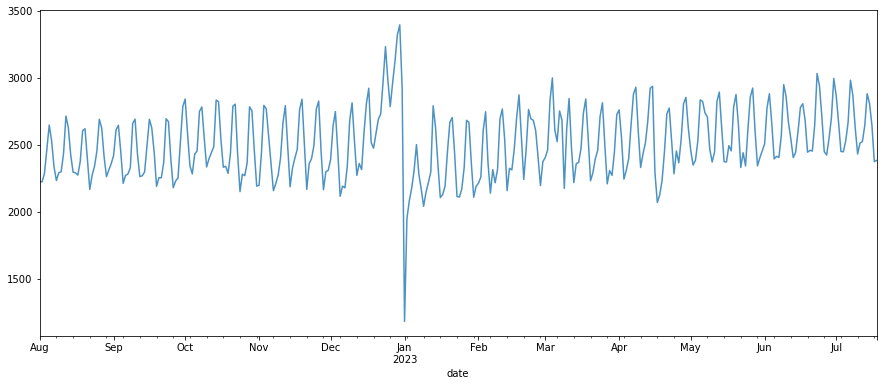

In [23]:
time_series_units = count_units.groupby('date')['date'].count()
plt.figure(figsize=(15, 6))
time_series_units.plot(ax=plt.gca(), alpha=0.8)
plt.show()

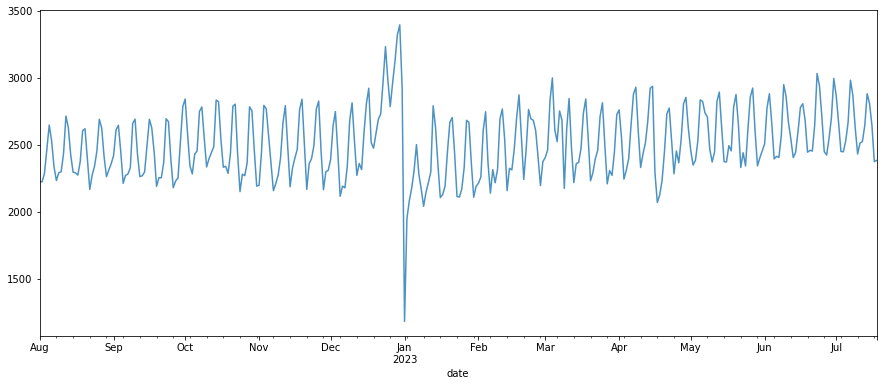

In [24]:
time_series_rub = count_rub.groupby('date')['date'].count()
plt.figure(figsize=(15, 6))
time_series_rub.plot(ax=plt.gca(), alpha=0.8)
plt.show()

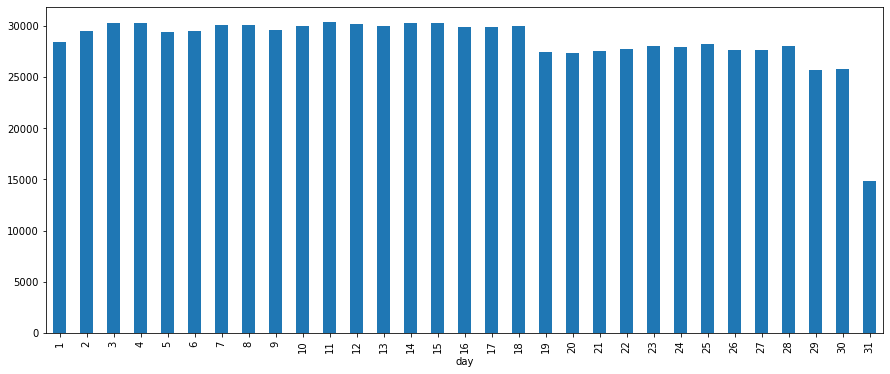

In [25]:
plt.figure(figsize=(15, 6))
df_clean.groupby('day')['pr_sales_in_units'].count().plot.bar()
plt.show()

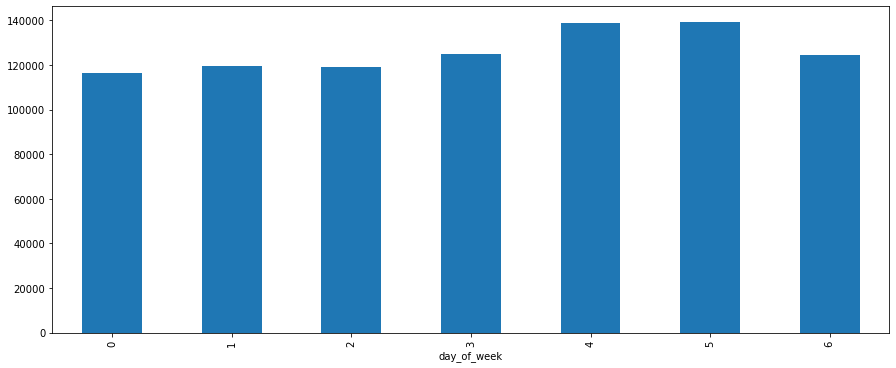

In [26]:
plt.figure(figsize=(15, 6))
df_clean.groupby('day_of_week')['pr_sales_in_units'].count().plot.bar()
plt.show()

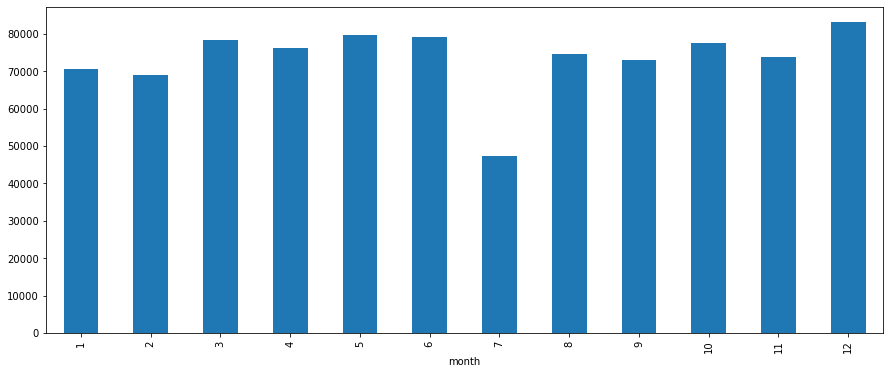

In [27]:
plt.figure(figsize=(15, 6))
df_clean.groupby('month')['pr_sales_in_units'].count().plot.bar()
plt.show()

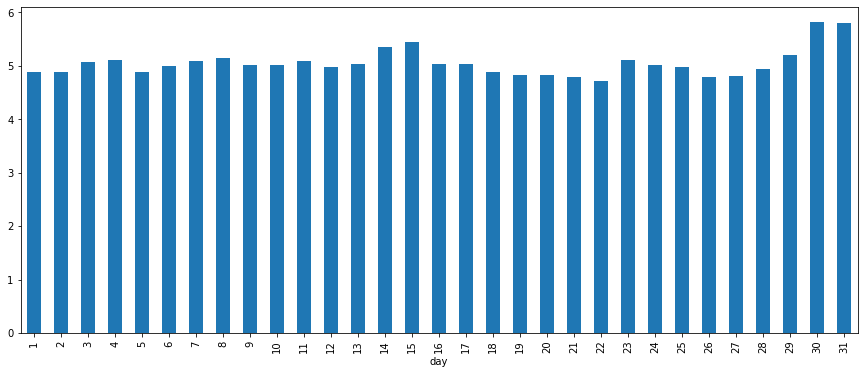

In [28]:
plt.figure(figsize=(15, 6))
df_clean.groupby('day')['pr_sales_in_units'].mean().plot.bar()
plt.show()

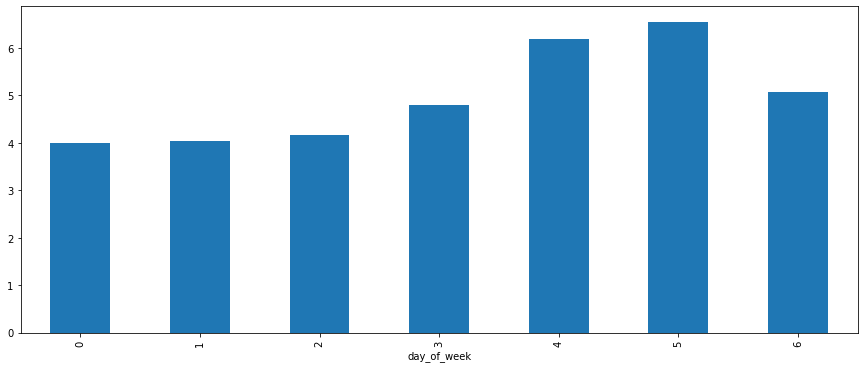

In [29]:
plt.figure(figsize=(15, 6))
df_clean.groupby('day_of_week')['pr_sales_in_units'].mean().plot.bar()
plt.show()

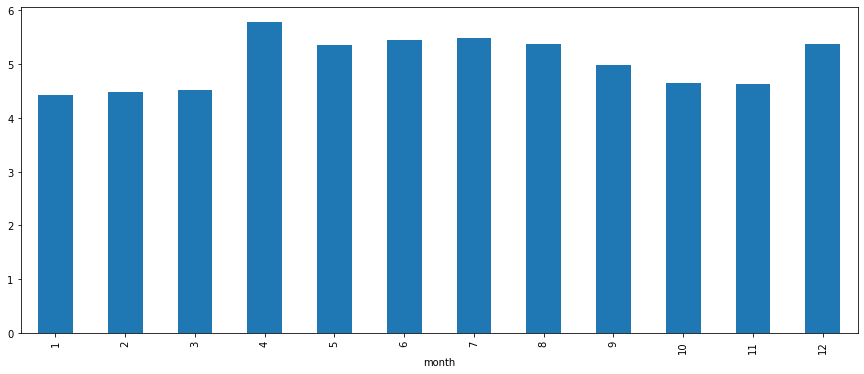

In [30]:
plt.figure(figsize=(15, 6))
df_clean.groupby('month')['pr_sales_in_units'].mean().plot.bar()
plt.show()

In [31]:
train, test = train_test_split(df_clean, shuffle=False, test_size=0.1)

In [32]:
list(train.columns.values)

['st_id',
 'pr_sku_id',
 'date',
 'pr_sales_type_id',
 'pr_sales_in_units',
 'pr_promo_sales_in_units',
 'pr_sales_in_rub',
 'pr_promo_sales_in_rub',
 'day_of_week',
 'day',
 'month',
 'year',
 'pr_group_id',
 'pr_cat_id',
 'pr_subcat_id',
 'pr_uom_id',
 'st_city_id',
 'st_division_code',
 'st_type_format_id',
 'st_type_loc_id',
 'st_type_size_id',
 'st_is_active']

In [33]:
f_train = train.drop(['pr_sales_in_units', 'pr_promo_sales_in_units','pr_sales_in_rub','pr_promo_sales_in_rub'], axis= 1)
t_train = train['pr_sales_in_units']

In [34]:
model = lgb.LGBMRegressor(boosting_type= 'gbdt', random_state=12345
                         )
param_search = {'max_depth' : [20, 50], "n_estimators": [50, 100, 200],
               'learning_rate': [0.1, 0.25, 0.5]}

my_cv = TimeSeriesSplit(n_splits=6).split(f_train)

gsearch = RandomizedSearchCV(estimator=model, cv=my_cv,
                        param_distributions=param_search)
gsearch.fit(f_train, t_train)

C:\Users\Star\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Star\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Star\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "C:\Users\Star\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "C:\Users\Star\anaconda3\l

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: st_id, pr_sku_id, date, pr_group_id, pr_cat_id, pr_subcat_id, st_city_id, st_division_code

In [35]:
gsearch.best_estimator_

LGBMRegressor(max_depth=20, n_estimators=200, random_state=12345)

In [37]:
lgbm_model = gsearch.best_estimator_

In [38]:
prediction_lgbm = lgbm_model.predict(f_train)
lgbm_rmse_tr = mean_squared_error(prediction_lgbm, t_train)**0.5

prediction_lgbm = lgbm_model.predict(f_test)
lgbm_rmse = mean_squared_error(prediction_lgbm, t_test)**0.5

print("RMSE тестовой выборки: ",lgbm_rmse)

print("RMSE обучающей выборки: ",lgbm_rmse_tr)

NotFittedError: Estimator not fitted, call fit before exploiting the model.